In [1]:
import nasdaqdatalink
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
nasdaqdatalink.read_key("/data/.apikey")
SOC35 = nasdaqdatalink.get('UMICH/SOC35')

In [3]:
SOC35.tail()

,Good time to buy,Uncertain - depends,Bad time to buy,Relative
Date,,,,
2022-08-31,32.0,5.0,63.0,69.0
2022-09-30,34.0,5.0,61.0,73.0
2022-10-31,42.0,6.0,52.0,90.0
2022-11-30,34.0,5.0,61.0,73.0
2022-12-31,36.0,5.0,59.0,77.0


In [4]:
target = pd.read_csv('data/USREC.csv')
target['DATE'] = pd.to_datetime(target['DATE'])

In [5]:
target.tail()

,DATE,USREC
2003,2021-11-01,0
2004,2021-12-01,0
2005,2022-01-01,0
2006,2022-02-01,0
2007,2022-03-01,0


In [6]:
ten_year_treas = nasdaqdatalink.get('FRED/DGS10')

In [7]:
ten_year_treas

,Value
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03
...,...
2022-07-11,2.99
2022-07-12,2.96
2022-07-13,2.91


In [8]:
three_month_treas = nasdaqdatalink.get('FRED/DTB3')
combined = three_month_treas.join(ten_year_treas, how='left', lsuffix='_3mon', rsuffix='_10yr')
combined = combined.dropna()
combined['spread'] = combined['Value_10yr'] - combined['Value_3mon']

In [9]:
three_month_treas

,Value
Date,
1954-01-04,1.33
1954-01-05,1.28
1954-01-06,1.28
1954-01-07,1.31
1954-01-08,1.31
...,...
2022-07-11,2.13
2022-07-12,2.16
2022-07-13,2.33


In [10]:
combined

,Value_3mon,Value_10yr,spread
Date,,,
1962-01-02,2.70,4.06,1.36
1962-01-03,2.73,4.03,1.30
1962-01-04,2.72,3.99,1.27
1962-01-05,2.74,4.02,1.28
1962-01-08,2.78,4.03,1.25
...,...,...,...
2022-07-11,2.13,2.99,0.86
2022-07-12,2.16,2.96,0.80
2022-07-13,2.33,2.91,0.58


In [11]:
#Take average by month in yield
yield_by_month_mean = combined.groupby(pd.Grouper(freq='M')).mean()

#Format yield into monthly datetime
yield_by_month_mean = yield_by_month_mean.set_index(yield_by_month_mean.index.strftime('%Y-%m'))

#Format target into YYYY-MM
target['DATE'] = target['DATE'].apply(lambda x: x.strftime('%Y-%m'))
target = target.set_index(target['DATE']).drop(columns = ['DATE'])

<AxesSubplot:xlabel='Date'>

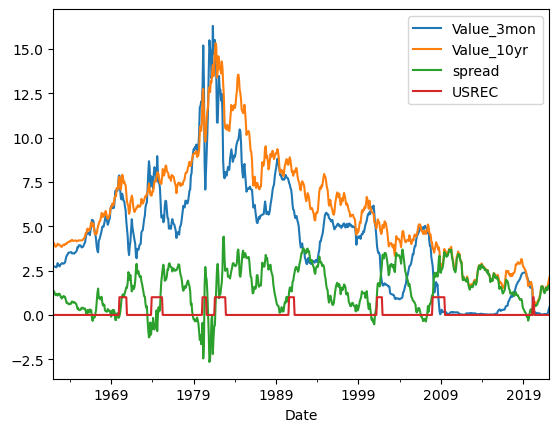

In [12]:
recession_vs_yield = yield_by_month_mean.join(target, how = 'left').dropna()
recession_vs_yield = recession_vs_yield.set_index(pd.DatetimeIndex(recession_vs_yield.index))
recession_vs_yield.plot()

In [13]:
#Include michigan state university data on current levels of fear WRT the economy
SOC35 = SOC35.set_index(SOC35.index.strftime('%Y-%m'))
date_index = recession_vs_yield.index.strftime('%Y-%m')
recession_vs_yield = recession_vs_yield.set_index(date_index)
recession_vs_yield = SOC35.join(recession_vs_yield, how = 'right')

In [14]:
# TO-DO: MAKE OFFSET RECESSION VALUE AND BIN INFO
# TO-DO: GET MORE INDICATORS
# TO-DO: 
# TO-DO: 

In [15]:
#try out the model
recession_vs_yield.to_csv('data/preprocessed.csv')

In [16]:
recession_vs_yield

,Good time to buy,Uncertain - depends,Bad time to buy,Relative,Value_3mon,Value_10yr,spread,USREC
Date,,,,,,,,
1962-01,NaN,NaN,NaN,NaN,2.719545,4.083182,1.363636,0.0
1962-02,NaN,NaN,NaN,NaN,2.732778,4.039444,1.306667,0.0
1962-03,NaN,NaN,NaN,NaN,2.723182,3.930455,1.207273,0.0
1962-04,NaN,NaN,NaN,NaN,2.729500,3.843000,1.113500,0.0
1962-05,NaN,NaN,NaN,NaN,2.685000,3.873636,1.188636,0.0
...,...,...,...,...,...,...,...,...
2021-11,37.0,5.0,58.0,79.0,0.051500,1.559500,1.508000,0.0
2021-12,39.0,4.0,57.0,82.0,0.060000,1.465000,1.405000,0.0
2022-01,37.0,5.0,58.0,79.0,0.149500,1.764000,1.614500,0.0


In [17]:
#Civilian Unemployment Rate 
unemployment = nasdaqdatalink.get('FRED/UNRATE')

In [18]:
import requests

In [19]:
# function to download data from fred
def fred_download(series_id, api_key):
    url = 'https://api.stlouisfed.org/fred/series/observations?series_id=' + series_id + '&api_key=' + api_key + '&file_type=json'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['observations'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df.drop(columns = ['realtime_start', 'realtime_end'])
    df = df.rename(columns = {'value': series_id})
    return df

In [20]:
unemp = fred_download('UNRATE', '4582031f930830a9e531b95f4f79f677')

In [21]:
unemp.tail()

,UNRATE
date,
2022-08-01,3.7
2022-09-01,3.5
2022-10-01,3.7
2022-11-01,3.6
2022-12-01,3.5


In [22]:
unemployment.tail()

,Value
Date,
2021-09-01,4.7
2021-10-01,4.6
2021-11-01,4.2
2021-12-01,3.9
2022-01-01,4.0


In [23]:
#matching the dates to the main 
from datetime import datetime
unemployment=unemployment.loc[datetime.fromisoformat('1962-01-01'):,:]

In [24]:

date_index_2 = unemployment.index.strftime('%Y-%m')
unemployment = unemployment.set_index(date_index_2)

In [25]:
#combine unemplyoment to the main date
combined_2 = unemployment.join(recession_vs_yield,how='right')

In [26]:
#testing the joint 
combined_2

,Value,Good time to buy,Uncertain - depends,Bad time to buy,Relative,Value_3mon,Value_10yr,spread,USREC
Date,,,,,,,,,
1962-01,5.8,NaN,NaN,NaN,NaN,2.719545,4.083182,1.363636,0.0
1962-02,5.5,NaN,NaN,NaN,NaN,2.732778,4.039444,1.306667,0.0
1962-03,5.6,NaN,NaN,NaN,NaN,2.723182,3.930455,1.207273,0.0
1962-04,5.6,NaN,NaN,NaN,NaN,2.729500,3.843000,1.113500,0.0
1962-05,5.5,NaN,NaN,NaN,NaN,2.685000,3.873636,1.188636,0.0
...,...,...,...,...,...,...,...,...,...
2021-11,4.2,37.0,5.0,58.0,79.0,0.051500,1.559500,1.508000,0.0
2021-12,3.9,39.0,4.0,57.0,82.0,0.060000,1.465000,1.405000,0.0
2022-01,4.0,37.0,5.0,58.0,79.0,0.149500,1.764000,1.614500,0.0


In [27]:
#Housing market data 
housing_market_data = nasdaqdatalink.get('YALE/RHPI')
housing_market_data = housing_market_data.loc[datetime.fromisoformat('1962-01-01'):,:]

In [28]:
date_index_3 = housing_market_data.index.strftime('%Y-%m')
housing_market_data = housing_market_data.set_index(date_index_3)

In [29]:
#changing coulmn name 
housing_market_data.rename({'Index':'housing market'},axis=1,inplace=True)

In [30]:
housing_market_data

,housing market
Date,
1962-01,109.981774
1962-02,109.380905
1962-03,109.380905
1962-04,109.018717
1962-05,109.605470
...,...
2021-10,210.745812
2021-11,211.922256
2021-12,211.973616


In [31]:
#combined housing market data 
combined_3 = housing_market_data.join(combined_2,how='right')

In [32]:
# checking for nan - all good! 
combined_3.isna().sum()

housing market           1
Value                    2
Good time to buy       192
Uncertain - depends    192
Bad time to buy        192
Relative               192
Value_3mon               0
Value_10yr               0
spread                   0
USREC                    0
dtype: int64

In [27]:
combined_3

,housing market,Value,Good time to buy,Uncertain - depends,Bad time to buy,Relative,Value_3mon,Value_10yr,spread,USREC
Date,,,,,,,,,,
1962-01,109.981774,5.8,NaN,NaN,NaN,NaN,2.719545,4.083182,1.363636,0.0
1962-02,109.380905,5.5,NaN,NaN,NaN,NaN,2.732778,4.039444,1.306667,0.0
1962-03,109.380905,5.6,NaN,NaN,NaN,NaN,2.723182,3.930455,1.207273,0.0
1962-04,109.018717,5.6,NaN,NaN,NaN,NaN,2.729500,3.843000,1.113500,0.0
1962-05,109.605470,5.5,NaN,NaN,NaN,NaN,2.685000,3.873636,1.188636,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-11,211.922256,4.2,37.0,5.0,58.0,79.0,0.051500,1.559500,1.508000,0.0
2021-12,211.973616,3.9,39.0,4.0,57.0,82.0,0.060000,1.465000,1.405000,0.0
2022-01,212.529443,4.0,37.0,5.0,58.0,79.0,0.149500,1.764000,1.614500,0.0
